# Churn prediction with XGboost (Work Flow)
1. Split dataset
    A.
    B. Training
    C. Validation
2. Modelling
    A. Xgboost
3. Model evaluation
    A. Accuracy, Precision, Recall
    B. ROC-AUC
    C. Stratified K-fold validation
4. Model finetuning
    A. Random search with cross validation
5. Understanding the model
    A. Feature importance
    B. Partial dependence plot (PDP)
    C. SHAP

In [19]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
# import shap
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [50]:
sns.set(color_codes = True)

# Load Data

In [20]:
train_data = pd.read_pickle('feature_engineered_train_data.pkl')
history_data = pd.read_pickle('feature_engineered_history_data.pkl')

In [24]:
history_data

,id,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,44.531877,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,45.501268,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,40.766185,24.486748,16.328003
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,44.414856,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972,41.035291,24.752581,16.588752
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000,44.458512,0.000000,0.000000
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569,41.314049,25.025265,16.858411
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678,40.730558,24.467516,16.316414


In [23]:
train_data.isnull().sum()

id                           0
cons_12m                     0
cons_gas_12m                 0
cons_last_month              0
date_activ                   0
date_end                     0
date_modif_prod              0
date_renewal                 0
forecast_cons_12m            0
forecast_cons_year          25
forecast_discount_energy     0
forecast_meter_rent_12m      0
forecast_price_energy_p1     0
forecast_price_energy_p2     0
forecast_price_pow_p1        0
has_gas                      0
imp_cons                     0
margin_gross_pow_ele         0
margin_net_pow_ele           0
nb_prod_act                  0
net_margin                   0
num_years_antig              0
pow_max                      0
churn                        0
tenure                       0
month_activ                  0
month_to_end                 0
month_modif_prod             0
month_renewal                0
channel_epu                  0
channel_ewp                  0
channel_fix                  0
channel_

In [25]:
train = train_data.merge(history_data, on = 'id')

In [26]:
train

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,activity_wxe,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3
0,48ada52261e7cf58715202705a0451c9,5.490346,0.000000,4.001128,2012-11-07,2016-11-06,2012-11-07,2015-11-09,4.423595,4.001128,...,0,0.103449,0.092115,0.067241,58.956502,36.356887,8.337051,59.059950,36.449002,8.404292
1,24011ae4ebbe3035111d65fa7c15bc57,4.327104,4.739944,0.000000,2013-06-15,2016-06-15,2015-11-01,2015-06-23,3.085953,0.000000,...,0,0.122856,0.102137,0.072579,40.640023,24.384011,16.256008,40.762879,24.486148,16.328586
2,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2009-08-21,2016-08-30,2009-08-21,2015-08-31,2.280920,0.000000,...,0,0.149934,0.000000,0.000000,44.315416,0.000000,0.000000,44.465350,0.000000,0.000000
3,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,2010-04-16,2016-04-16,2010-04-16,2015-04-17,1.689841,0.000000,...,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000
4,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2010-03-30,2016-03-30,2010-03-30,2015-03-31,2.382089,0.000000,...,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,18463073fb097fc0ac5d3e040f356987,4.508812,4.680707,0.000000,2012-05-24,2016-05-08,2015-05-08,2014-05-26,3.667360,0.000000,...,0,0.144124,0.000000,0.000000,44.370635,0.000000,0.000000,44.514760,0.000000,0.000000
16092,d0a6f71671571ed83b2645d23af6de00,3.858778,0.000000,2.260071,2012-08-27,2016-08-27,2012-08-27,2015-08-28,2.801191,2.260071,...,0,0.106799,0.095406,0.070817,59.015674,36.393379,8.345418,59.122473,36.488785,8.416235
16093,10e6828ddd62cbcf687cb74928c4c2d2,3.265996,0.000000,2.255273,2012-02-08,2016-02-07,2012-02-08,2015-02-09,2.281919,2.255273,...,0,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854
16094,1cf20fd6206d7678d5bcafd28c53b4db,2.120574,0.000000,0.000000,2012-08-30,2016-08-30,2012-08-30,2015-08-31,3.099541,0.000000,...,0,0.149934,0.000000,0.000000,44.315416,0.000000,0.000000,44.465350,0.000000,0.000000


In [28]:
date_columns = ['date_activ','date_end','date_modif_prod','date_renewal']
train.drop(columns = date_columns, inplace=True)
pd.DataFrame({'Df Columns': train.columns})

,Df Columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_cons_year
6,forecast_discount_energy
7,forecast_meter_rent_12m
8,forecast_price_energy_p1
9,forecast_price_energy_p2


# Model

## Splitting data

In [29]:
y = train['churn']
X = train.drop(columns = ['id', 'churn'], axis = 1)

In [30]:
X

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,...,activity_wxe,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3
0,5.490346,0.000000,4.001128,4.423595,4.001128,0.0,2.556652,0.095919,0.088347,43.094358,...,0,0.103449,0.092115,0.067241,58.956502,36.356887,8.337051,59.059950,36.449002,8.404292
1,4.327104,4.739944,0.000000,3.085953,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,0,0.122856,0.102137,0.072579,40.640023,24.384011,16.256008,40.762879,24.486148,16.328586
2,3.668479,0.000000,0.000000,2.280920,0.000000,0.0,1.237292,0.145711,0.000000,44.311378,...,0,0.149934,0.000000,0.000000,44.315416,0.000000,0.000000,44.465350,0.000000,0.000000
3,2.736397,0.000000,0.000000,1.689841,0.000000,0.0,1.599009,0.165794,0.087899,44.311378,...,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000
4,3.200029,0.000000,0.000000,2.382089,0.000000,0.0,1.318689,0.146694,0.000000,44.311378,...,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,4.508812,4.680707,0.000000,3.667360,0.000000,0.0,1.291591,0.138305,0.000000,44.311378,...,0,0.144124,0.000000,0.000000,44.370635,0.000000,0.000000,44.514760,0.000000,0.000000
16092,3.858778,0.000000,2.260071,2.801191,2.260071,0.0,2.161458,0.100167,0.091892,43.094358,...,0,0.106799,0.095406,0.070817,59.015674,36.393379,8.345418,59.122473,36.488785,8.416235
16093,3.265996,0.000000,2.255273,2.281919,2.255273,0.0,2.115943,0.116900,0.100015,40.606701,...,0,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854
16094,2.120574,0.000000,0.000000,3.099541,0.000000,0.0,0.912753,0.145711,0.000000,44.311378,...,0,0.149934,0.000000,0.000000,44.315416,0.000000,0.000000,44.465350,0.000000,0.000000


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.25, random_state=18)

## Modeling

In [33]:
model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 6, n_estimators = 500, n_jobs = -1)
result = model.fit(X_train, y_train)

/home/brian/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Model evaluation
Here using **Accuracy, Precision, Recall**:

    Accuracy = Correct Observation / All Observation
    Precision = The ratio of correctly predicted positive observations to the total predicted positive observations(True Positive / True Positive + False Positive)
    Recall = The ratio of correctly predicted positive observations to the all observations in actual class(True Positive / True Positive + False Negatvie)

In [35]:
def evaluate(model_, X_test_, y_test_):
    # Get model prediction
    prediction_test_ = model_.predict(X_test)
    
    # Print the evaluation metrics as Df
    results = pd.DataFrame({ "Accuracy" : [metrics.accuracy_score(y_test_, prediction_test_)],
                            "Precision": [metrics.precision_score(y_test_, prediction_test_)],
                            "Recall": [metrics.recall_score(y_test_, prediction_test_)]
                            })
    
    return results
    

In [37]:
evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall
0,0.905815,0.7,0.151807


## ROC-AUC
In a nutshell, it tells how much model is capable of distinguishing between classes.  

[model.predict_proba Usage](https://blog.csdn.net/u011630575/article/details/79429757)  

[metrics.roc_curve Usage](https://www.itread01.com/content/1543836134.html)

In [55]:
def calculate_roc_auc(model_, X_test_,y_test_):
    # Get the model predictions
    # Note that we are using the prediction for the class 1 -> churn
    prediction_test_ = model_.predict_proba(X_test_)[:,1]
    
    # Compute ROC-AUC
    # Will return different "True Positive Rate", "False Positive Rate" given different thresholds
    fpr, tpr, thresholds = metrics.roc_curve(y_test_, prediction_test_)
    
    score = pd.DataFrame({'ROC-AUC': [metrics.auc(fpr,tpr)]})
    
    return fpr,tpr,score,thresholds

def plot_roc_auc(fpr,tpr):
    f, ax = plt.subplots(figsize = (14,8))
    # Plot ROC
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha = 0.3, label = 'AUC = {:.2f}'.format(roc_auc))
    # Plot random  line
    plt.plot([0,1], [0,1], linestyle ='--', lw=3, color = 'r', label = "Random", alpha = 0.8)
                
    ax.set_xlabel("False Positive Rate(FPR)")
    ax.set_ylabel("True Positive Rate(TPR)")    
    ax.set_title("ROC-AUC")
    ax.legend(loc='lower right')
    plt.show()

In [44]:
fpr, tpr, auc_score,thresholds = calculate_roc_auc(model, X_test, y_test)

In [46]:
auc_score

,ROC-AUC
0,0.683895


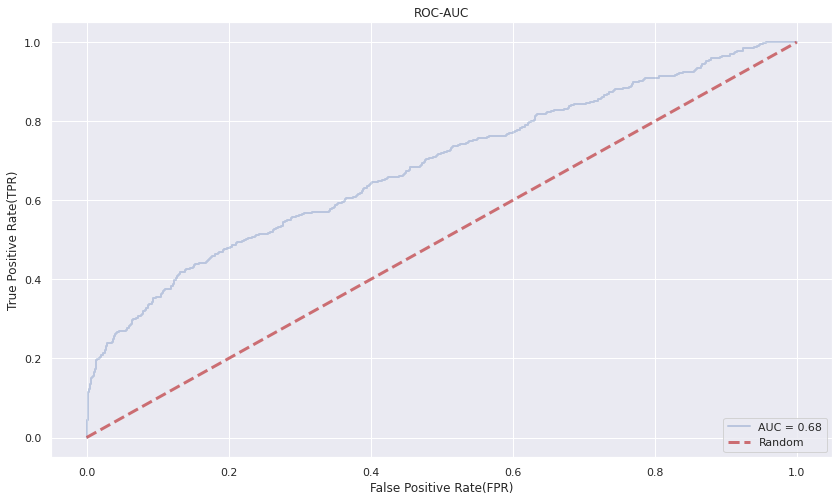

In [56]:
plot_roc_auc(fpr, tpr)

## Stratified K-fold validation
After first test,train split, we cannot assure that is the best way to split the data set  
By using K-fold validation, we can know a better way to split data

In [102]:
def plot_roc_curve(fprs, tprs):
    """
    Plot thge ROC from a list
    of
    """
    # Initilize useful lists + plot axes
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    f,ax = plt.subplots(figsize=(18,10))
    
    #PLot ROC for each K-Fold + compute AUC socres
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0]=0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=2, alpha=0.3, 
                   label = "ROC fold {}: AUC {:.2f}".format(i, roc_auc))
    
    # Plot luck line
    plt.plot([0,1], [0,1], linestyle = '--', lw=3, color = 'r',label = "Random", alpha=.8)
        
    # Plot the mean ROC
    mean_tpr = np.mean(tprs_interp, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color = 'b', label = "Mean ROC (AUC: {:.2f} STD{:.2f})".format(mean_auc, std_auc),lw = 4, alpha=0.8)
    
    # set plot
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title("ROC-AUC")
    ax.legend(loc = 'lower right')
    plt.show()
    return (f, ax)
    
    
def compute_roc_auc(model_, index):
    y_predict = model_.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict)
    auc_score = metrics.auc(fpr,tpr)
    return fpr, tpr,auc_score
    
    

In [82]:
cv = StratifiedKFold(n_splits = 5, random_state=13, shuffle=True) # Perform 5-fold validation
# These three array is used to store fpr, tpr, score for different fold validation
fprs, tprs, scores = [],[],[] 

In [95]:
model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 6, n_estimators = 500, n_jobs = -1, use_label_encoder=False)

for (train, test), i in zip(cv.split(X,y), range(5)):
    # Fit model by each fold of dataset
    # KEY, cv split完之後, 是回傳index, 因此要用iloc來assign 位置 
    model.fit(X.loc[train], y.loc[train])
    
    # After train the model, send train data to get the auc_score
    _, _, auc_score_train = compute_roc_auc(model, train)
    # Use test data to get auc_score
    fpr, tpr, auc_score = compute_roc_auc(model, test)
    scores.append((i, auc_score_train, auc_score))
    # append fpr, tpr, for this fold to final list
    fprs.append(fpr)
    tprs.append(tpr)

[17:40:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [97]:
scores

[(0, 0.9994150632364068, 0.6847022808046949),
 (1, 0.9994542276784592, 0.696179872446222),
 (2, 0.99931493042298, 0.6846297697546211),
 (3, 0.9995963622204225, 0.6784725975570209),
 (4, 0.9994781419502534, 0.7021186898713653)]

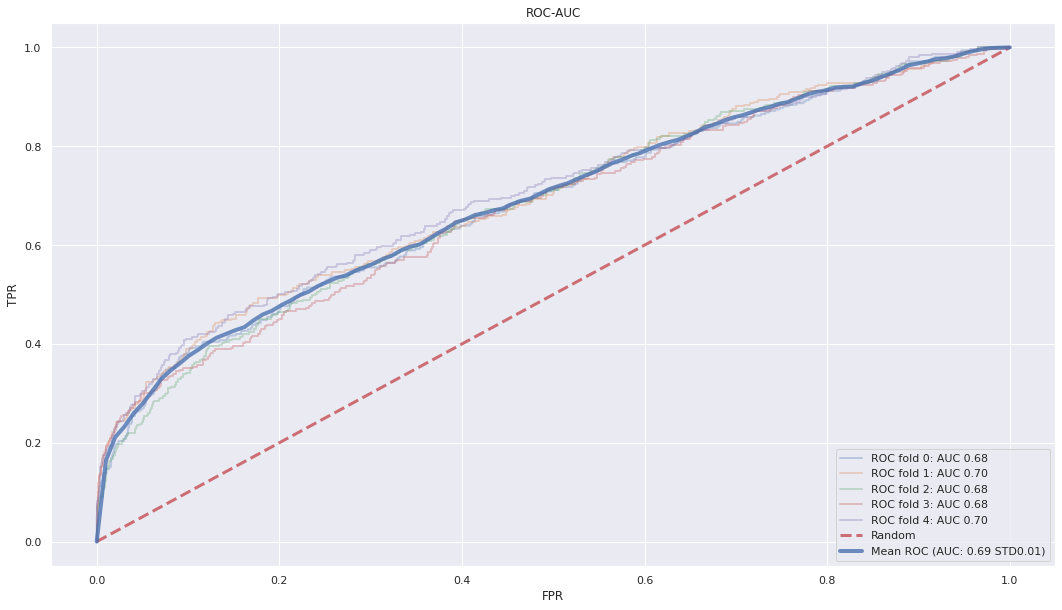

(<Figure size 1296x720 with 1 Axes>,
 <AxesSubplot:title={'center':'ROC-AUC'}, xlabel='FPR', ylabel='TPR'>)

In [103]:
plot_roc_curve(fprs,tprs)

##  Model finetuning

###  RandomizedSearchCV

In [145]:
from sklearn.model_selection import RandomizedSearchCV

In [151]:
# Create the random grid
params = { 'min_child_weight': [i for i in np.arange(1,15,1)], 
          'gamma': [i for i in np.arange(0,6,0.5)],
          'subsample': [i for i in np.arange(0,1.1,0.1)],
          'colsample_bytree': [i for i in np.arange(0,1.1,0.1)], 
          'max_depth': [i for i in np.arange(1,15,1)],
          'scale_pos_weight':[i for i in np.arange(1,15,1)], 
          'learning_rate': [i for i in np.arange(0,0.15,0.01)],
          'n_estimators' : [i for i in np.arange(0,2000,100)]
         }


In [162]:
# Create modeL
xg = xgb.XGBClassifier( nthread=1, use_label_encoder=False)

In [163]:
# Random search of parameters, using 5
xg_random = RandomizedSearchCV(estimator = xg, param_distributions=params, n_iter=1, scoring= "roc_auc", 
                               n_jobs=4, cv=5, verbose=3, random_state=1001)
# Fit the random search model
xg_random.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[20:02:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                        

In [203]:
xg_random.best_params_
best_random = xg_random.best_params_
# best_random

best_random = {'subsample': 0.8, 
               'scale_pos_weight': 1, 
               'n_estimators': 1100, 
               'min_child_weight': 1, 
               'max_depth': 12,
               'learning_rate': 0.01, 
               'gamma': 4.0, 
               'colsample_bytree': 0.60}


In [204]:
# best_random['subsample']=0.8
best_random

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'n_estimators': 1100,
 'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.01,
 'gamma': 4.0,
 'colsample_bytree': 0.6}

In [175]:
# create a model with the parameters found
model_random = xgb.XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                                silent = True,
                                nthread = 1,
                                **best_random)
fprs, tprs, scores= [], [], []

In [142]:
#  Using best_random params provided by BCG
for (train, test), i in zip(cv.split(X,y), range(5)):
    model_random.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model_random, train)
    fpr, tpr, auc_score = compute_roc_auc(model_random, test)    
    scores.append((i,auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)    

[19:21:10] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:21:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:26] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:22:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluatio

In [143]:
scores

[(0, 0.9911554156307427, 0.7176824768023998),
 (1, 0.9907005908851766, 0.7080077829423845),
 (2, 0.9912302176955343, 0.7178483407199221),
 (3, 0.9911592179789928, 0.7040817208950383),
 (4, 0.9910743696022314, 0.7253248297481354)]

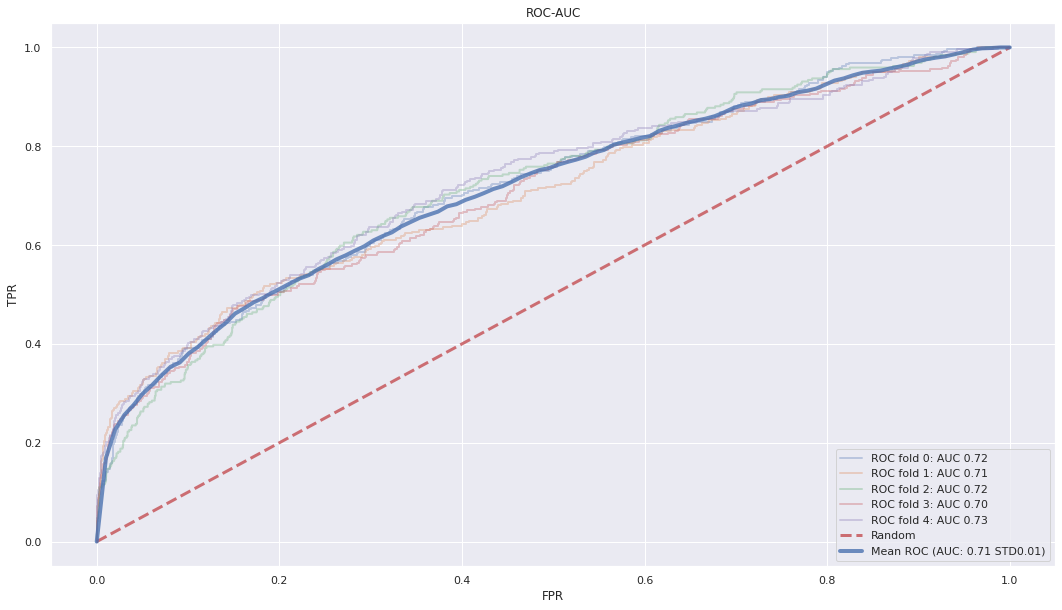

(<Figure size 1296x720 with 1 Axes>,
 <AxesSubplot:title={'center':'ROC-AUC'}, xlabel='FPR', ylabel='TPR'>)

In [144]:
plot_roc_curve(fprs, tprs)

### Grid search with cross validation (Time consuming)

In [179]:
from sklearn.model_selection import GridSearchCV

In [180]:
params_grid = { 'min_child_weight': [i for i in np.arange(1,15,1)], 
          'gamma': [i for i in np.arange(0,6,0.5)],
          'subsample': [i for i in np.arange(0,1.1,0.1)],
          'colsample_bytree': [i for i in np.arange(0,1.1,0.1)], 
          'max_depth': [i for i in np.arange(1,15,1)],
          'scale_pos_weight':[i for i in np.arange(1,15,1)], 
          'learning_rate': [i for i in np.arange(0,0.15,0.01)],
          'n_estimators' : [i for i in np.arange(0,2000,100)]
         }


In [184]:
xg = xgb.XGBClassifier(objective='binary:logistic', silent = False, nthread=1)

In [185]:
grid_search = GridSearchCV(estimator=xg, param_grid=params_grid, cv =5, n_jobs =-1, verbose =2, scoring ='roc_auc')


In [187]:
grid_search.fit(X_train, y_train)

In [ ]:
best_grid = grid_search.best_params_best_grid

In [ ]:
model_grid = xgb.XGBClassifier(objective='binary:logistic', silent=True, nthread=1, **best_grid)fprs, tprs, scores = [], [], []

In [ ]:
for (train, test), i in zip(cv.split(X, y), range(5)):
    model_grid.fit(X.iloc[train], y.iloc[train]) 
    _, _, auc_score_train = compute_roc_auc(model_grid, train) 
    fpr, tpr, auc_score = compute_roc_auc(model_grid, test) 
    scores.append((auc_score_train, auc_score)) 
    fprs.append(fpr) 
    tprs.append(tpr)

In [ ]:
plot_roc_curve(fprs, tprs)
plt.show()

# Understanding the model
## Feature importance
One simple way of boserving the feature importance is through counting the number of times each feature is split on across all boosting rounds (trees)in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear

In [190]:
model_random

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=2.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=6,
              silent=True, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

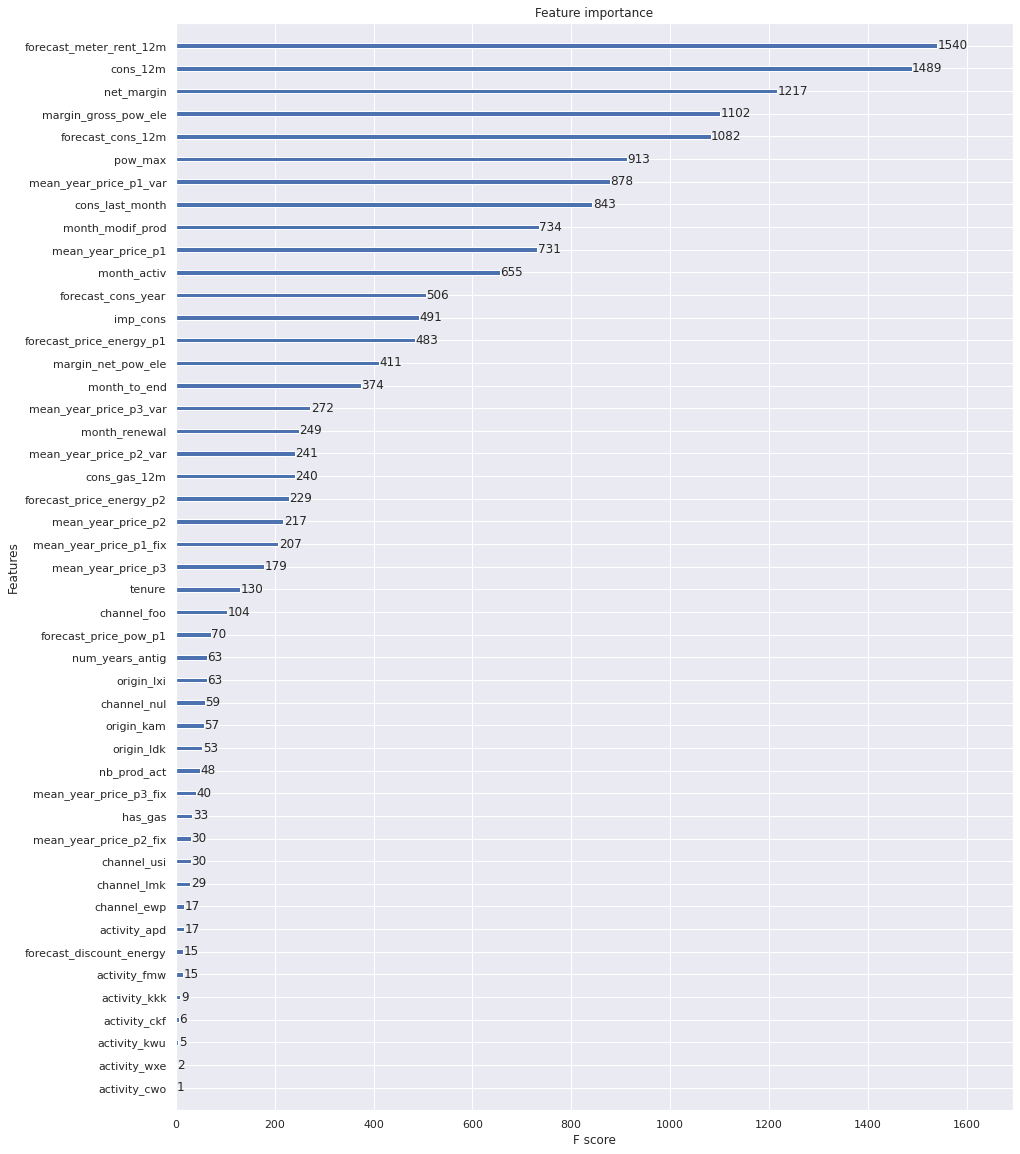

In [196]:
fig, ax = plt.subplots( figsize=(15,20) )
xgb.plot_importance(model_random, ax = ax)

In the feature importance graph above we can see that **cons_12m and net_margin** are the features that appear the most in our model andwe could infere that these two features have a significant importnace in our model

In [198]:
from sklearn.inspection import plot_partial_dependence

<Figure size 1080x1080 with 0 Axes>

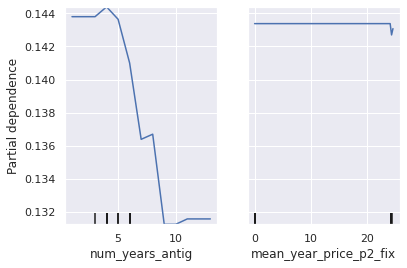

In [207]:
fig = plt.figure(figsize=(15,15))
plot_partial_dependence(model_random, X_test.values, features=[16, 49],
                        feature_names=X_test.columns.tolist())

# Business Impact of discount

##  Workflow
Task is to calculate the forecast revenue of the set of customers:

    1. When no discount is offered, and
    2. When a discount is offered based on some probability cut-off to decide who should receive a discount of 20%
    and therefore can decide the cut-off to maximise revenue.
    

In [216]:
predictions = pd.DataFrame(train_data)

In [217]:
predictions['predict_prob'] = model_random.predict_proba(X)[:,1]

### Calculate a baseline revenue estimate (no intervention)
Calculate a **baseline estimate of the electricity revenue for every customer for the next twelve months based on the forecast consumption and forecastprice and actual churn outcome.**
Call this **basecase_revenue**  

For customers who end up churning, we should reduce our forecast revenue calculation by 91.9% to account for the customers churn some time between January 2016 and the start of March 2016. (Not knowing when they churn, a reasonable assumption for the lost revenue is the averageof 100%, corresponding to churn on 1 January 2016, and 83.9%, corresponding to churn at the end of February, or 59 days into a 365 day year).Call this new variable **basecase_revenue_after_churn** , ie basecase_revenue_after_churn = basecase_revenue*(1-0.919*churn)

In [218]:
predictions['basecase_revenue'] = \
    (np.power(10, predictions['forecast_cons_12m']) +1 ) * predictions['forecast_price_energy_p1'] + predictions['forecast_meter_rent_12m']   
predictions['basecase_revenue_after_churn'] = predictions['basecase_revenue'] * (1 - 0.919*predictions['churn'])


###  Calculate the estimated benefits and costs of intervention
Pick a cut-off probability so that:

    * Customers with a higher churn probability than the cut-off get a discount, and
    * Customers below the churn-probability get a discount
    
From this, calculate the revenue of the intervention scenario of this scenario assuming:

    * All customers who are offered a discount accept it
    * Customers who do receive a discount are are assumed not to churn in the next twelve months (ie churn probability=0), and therefore the retainedrevenue is
    0.8*basecase_revenue , being  (1-discount_fraction)*basecase_revenue
    * Customers who do not receive a discount are assumed to churn based on the observed dependent variable (ie, a 1 or 0 for whether they actuallychurned or not

Now, map out the revenue delta as a function of the cut-off probability in a graph
**What cut-off probability approximately optimises the revenue outcome?**

Assume for these calculations that the customer does not consume more or less electricity because the price changes. (In practice, we would expectthat if the customer's cost goes down then their consumption might increase.)  

We will see two counterbalancing effects at play:

    * For true postives we will see revenue retention vs the no-discount scenario
    * For false positives we will see reduced revenue from giving them a discount when they wouldn't in fact churn
    
(False negatives represent an opportunity cost but not an actual cost difference between the two scenarios.)

The optimal cut-off point will balance the benefits from true positives against the costs of false positives.  

Our task is to approximately find the optimal cut-off point. We may need to make additional assumptions.  
If we feel the assumptions above aren't justified and that others are better then we should modify our assumptions.

In [236]:
def get_rev_delta(pred: pd.DataFrame, cutoff = 0.5, discount = 0.2):
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    
    # If predicted churn --> discount is given, customer will stay, but revenue hsa to be 1-discount * revenue
    pred.loc[pred['predict_prob'] >=cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    
    # Save
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    
    return pred['revenue_delta'].sum()
                                                            

In [237]:
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({ cutoff: get_rev_delta(predictions, cutoff= cutoff) for cutoff in np.arange(0, 1, 0.01)    
            })


In [239]:
# predictions[predictions['predict_prob'] > 0.5]
rev_deltas.value_counts()

281232.328869    1
282484.986240    1
286214.205028    1
284380.791139    1
286905.563591    1
                ..
192619.752634    1
287649.938142    1
284407.333607    1
248578.938632    1
285013.390047    1
Length: 100, dtype: int64

In [246]:
def plot_tradeoff(rev_deltas):
    rev_deltas.plot()
    
    # Mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s= 100, c='red')
    
    # Reference line for break-even
    plt.hlines(0,0,1, colors='black')
    plt.show()
    
    print('Maximum benefit at cutoff {} with revenue delta of {:.2f}'.format(max_pred, rev_deltas.loc[max_pred]))
    

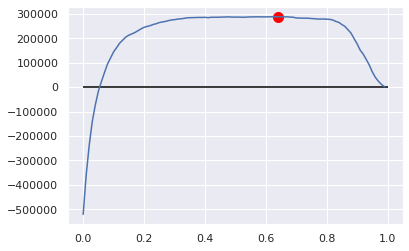

Maximum benefit at cutoff 0.64 with revenue delta of 288264.93


In [247]:
plot_tradeoff(rev_deltas)

##  How to select the discount?
In the strategy suggested by the SME division head we offer a 20% discount to all customer targeted. However, this might not be optimal either.  
  
We assumed before that customers offered a discount will not churn. However, that may not be true in reality. The discount may not be large enoughto prevent churn.  

In fact, we can predict the churn probability for each customer as a function of price, margin and other factors. Therefore, we can try to find a strategyfor each customer that optimises either their expected revenue or profit.  

In order to go further, we'll need to try to:

    1. Change the level of discount offered overall
    2. Predict the response of customers to that discount (ie, the churn probability) based on how much that discount affects their prices, the revenueand margin.
    3. Take care that we've applied the discount to all affected variables. To make this easier, we might want to retrain our model using a simpler setof variables where we know that we can factor the discount correctly into the predictors.
    4. Find the discount level that balances customer retention vs the cost of false positives.

In fact, this could be turned into a 2d optimisation problem:
    
    Objective: maximise net revenue(including the benefits of true positives and the cost of false positives)
    Decision variables:
        Level of discount offered, and
        Fraction of people who are offered a discount